In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from functools import reduce

In [2]:
organs = ['brain', 'colon', 'heart', 'kidney', 'liver', 'lung','soleus','spleen','testis']
dfs = {} # all data
counts = {} # only expressed data counts
for organ in organs:
    dfs[organ] = pd.read_csv(f'data/{organ}/Data.csv',index_col=0)
    counts[organ] = dfs[organ][dfs[organ]!=0].count(axis=1).to_frame(name='count')

gene list at least expressed min N number of cell

In [3]:
min_number = 300
data = {}
for o in organs:
    df = counts[o]
    data[o] = df[df['count']>min_number].index.to_list()

create DF contains genes for each tissue, expressed > min number of cell  
compute commons for all tissue  
check how many genes those genes are in the Universe (might be some missing but not that much)  
check common genes between each organ DE genes and Universe 

In [4]:
universe_list = pd.read_csv('data/universe_annotated.csv')
deg_list = pd.read_csv('data/deg_annotated.csv')
# genes expressed min N number of cell
x = pd.DataFrame.from_dict(data,'index').fillna(value=np.NaN).T
# genes that common for every organ
organ_commons = list(reduce(
    set.intersection, map(set, [x.brain, x.colon, x.heart, x.kidney, x.liver, x.lung,x.soleus,x.spleen,x.testis] )
))

# just filter out genes which does not exist in general annotation file
#common_universe = set.intersection(*[set(universe_list['name'].to_list()), set(organ_commons)])#
#common_deg = set.intersection(*[set(deg_list['name'].to_list()), set(organ_commons)])

universe_filter = {}
deg_filter = {}
for organ in x.columns:
    # common with Expressed min number cell & DEG
    organ_vs_universe = set(x[organ].dropna()) & set( universe_list['name'])
    organ_vs_deg = set(x[organ].dropna()) & set( deg_list['name'])
    universe_filter[organ] = list(organ_vs_universe)
    deg_filter[organ] = list(organ_vs_deg)
pd.DataFrame.from_dict(universe_filter, 'index').T
#pd.DataFrame.from_dict(common_genes_count, 'index').fillna(value=np.NaN).T.to_excel(f'deg_genes_for_{min_number}.xlsx')

,brain,colon,heart,kidney,liver,lung,soleus,spleen,testis
0,Rangap1,Rangap1,Pink1,Pink1,Rangap1,Rangap1,Pink1,Rangap1,Pink1
1,Pink1,Pink1,Lrrc8a,Lrrc8a,Pink1,Pink1,Lrrc8a,Pink1,Capza1
2,Lrrc8a,Lrrc8a,Arglu1,Arglu1,Lrrc8a,Lrrc8a,Arglu1,Capza1,Lrrc8a
3,Capza1,Capza1,Capza1,Capza1,Capza1,Capza1,Capza1,Lrrc8a,Rras
4,Rras,Rras,Rras,Rras,Rras,Rras,Rras,Rras,Arglu1
...,...,...,...,...,...,...,...,...,...
4857,None,None,None,None,None,None,None,Dnajc15,None
4858,None,None,None,None,None,None,None,Pigc,None
4859,None,None,None,None,None,None,None,Mgll,None
4860,None,None,None,None,None,None,None,Cep68,None


In [67]:
def do_corr(df):
    corr = df.corr(method='pearson')
    corr.index.names = ['genes']
    stack = corr.stack().reset_index()
    stack.columns = ['gene1', 'gene2', 'score']
    stack = stack[stack.gene1 != stack.gene2]
    stack = stack[stack.gene1.astype(str) < stack.gene2.astype(str)]
    threshold =  4 * stack['score'].std() + stack['score'].mean() # mean + 1.96 * std gives us %95 CI
    return stack, corr, threshold

In [84]:
def filter_corr_matrix(stack, rows, columns, threshold):
    # delete recurrent scores i.e. ABC XYZ, XYZ ABC
    matrix = stack.query(f'gene1 in {rows} and gene2 in {columns} or gene1 in {columns} and gene2 in {rows}').sort_values(by=['score'])
    stack = matrix[matrix.gene1.astype(str) < matrix.gene2.astype(str)]
    thresholded = matrix.query('score> @threshold')
    density = thresholded.index.size/matrix.index.size
    return matrix, thresholded, density

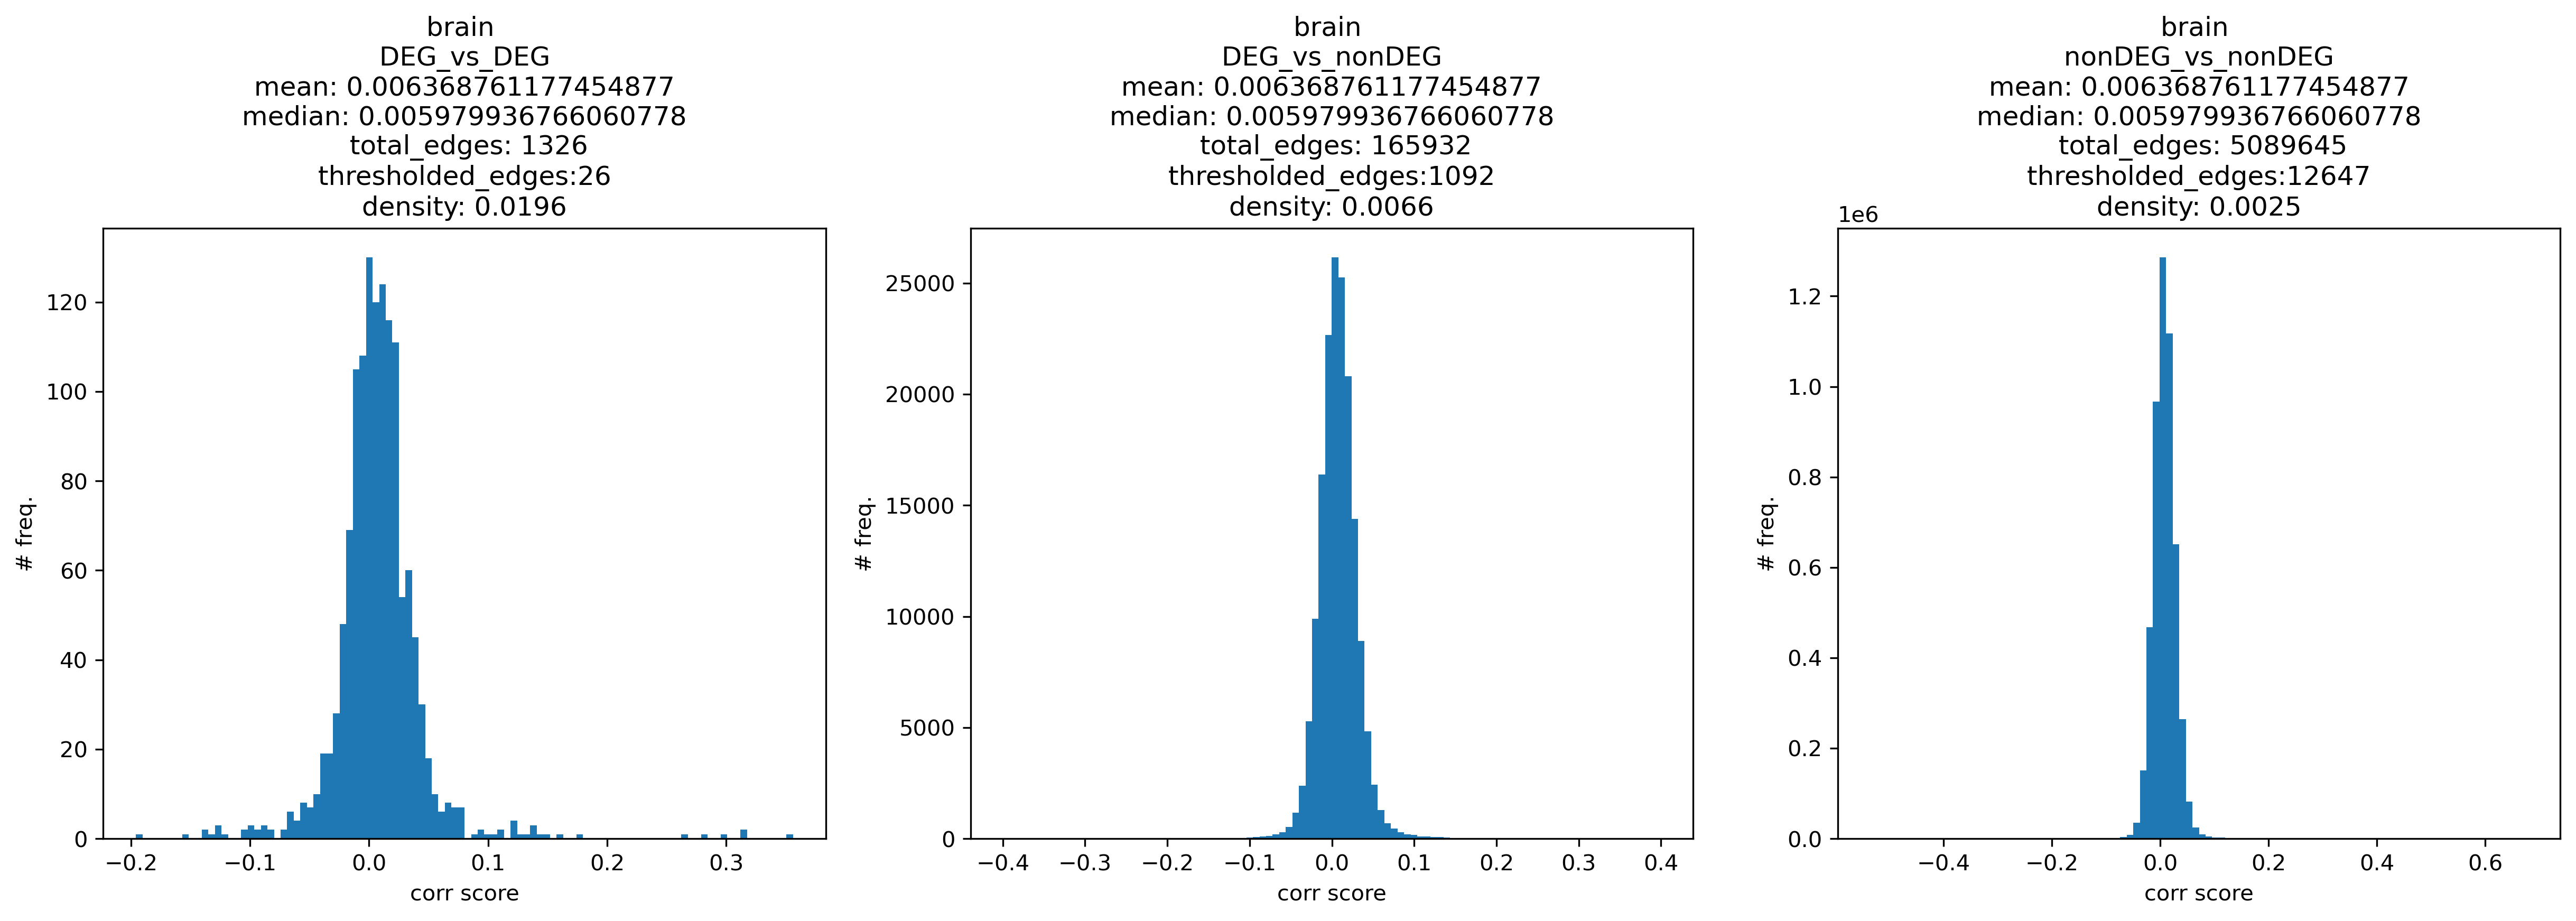

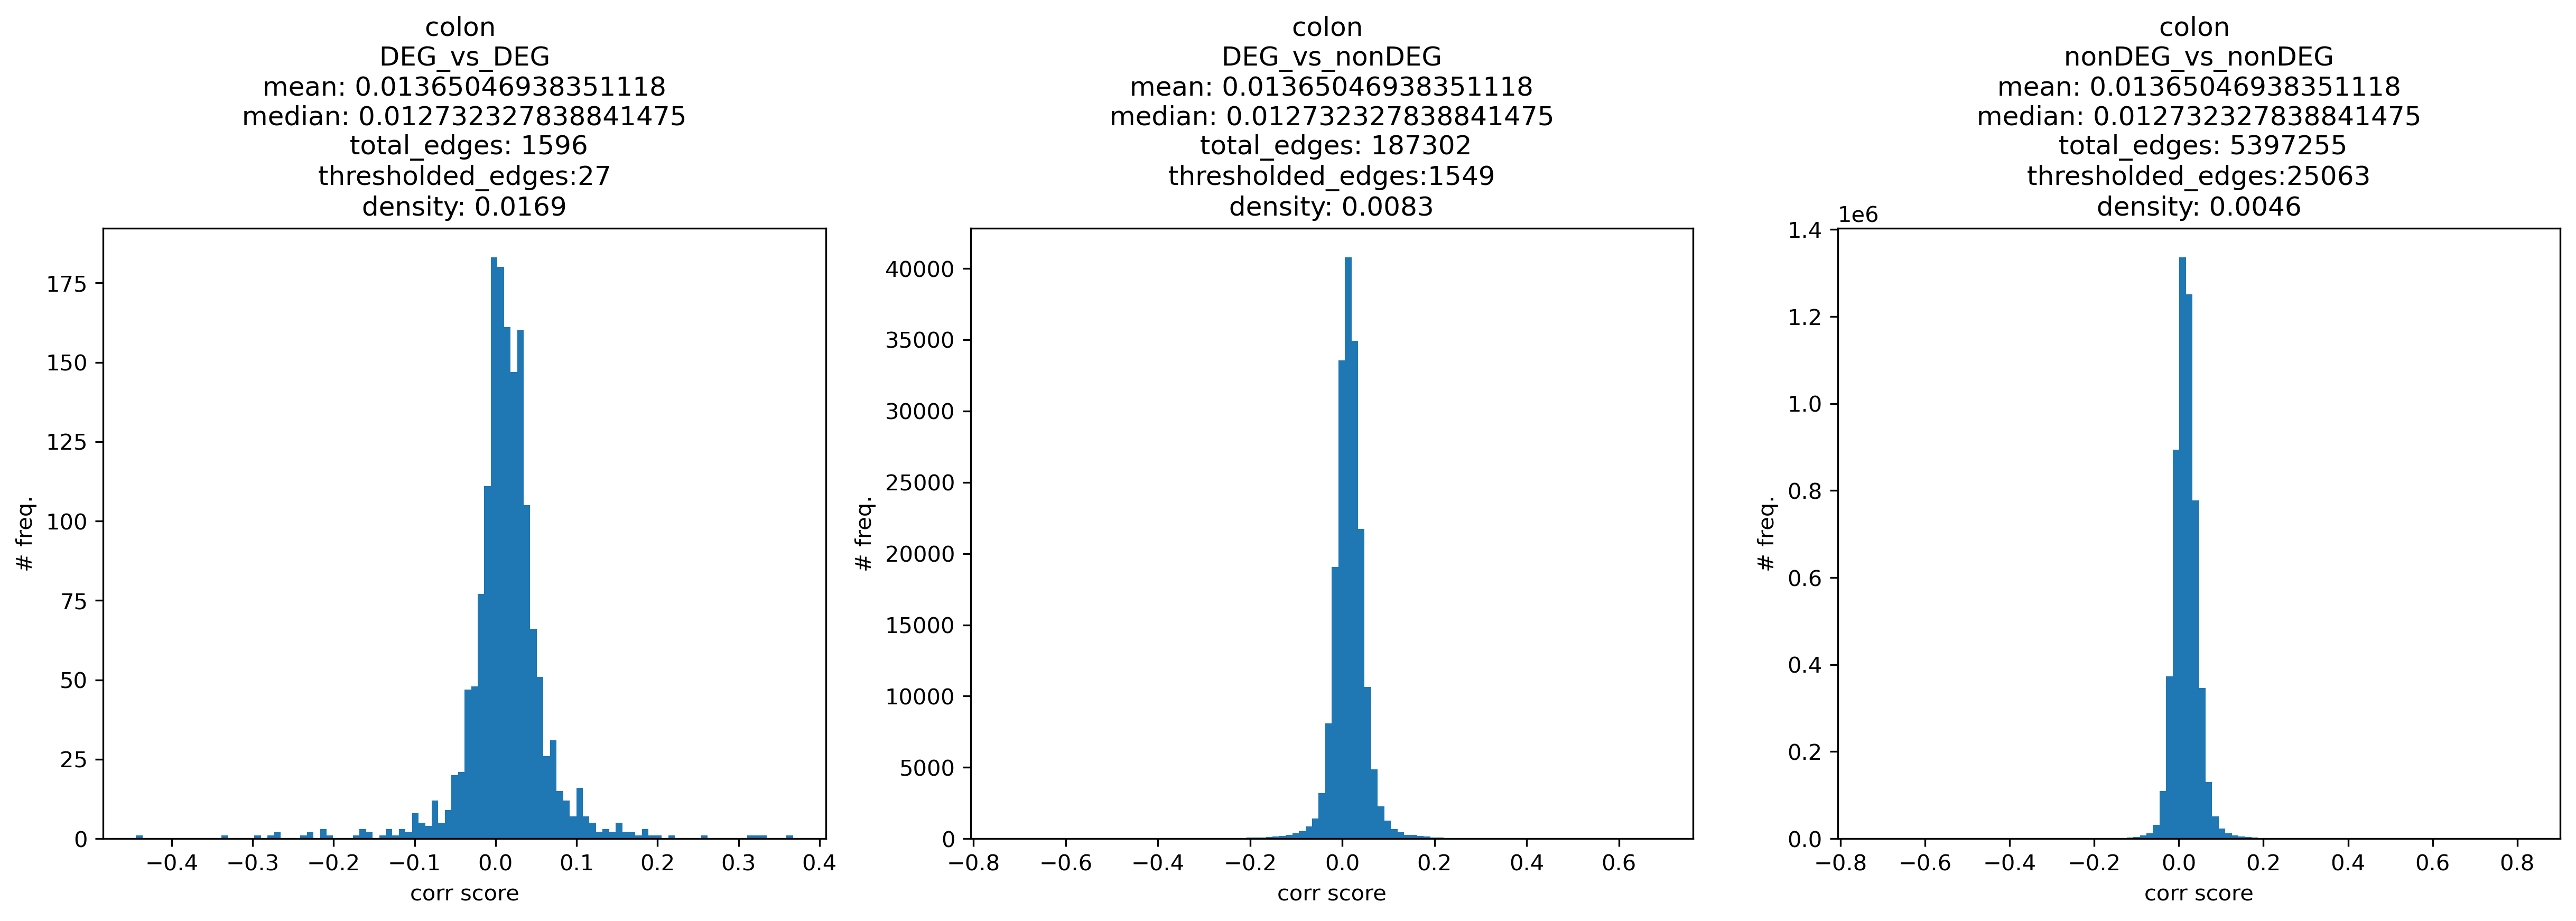

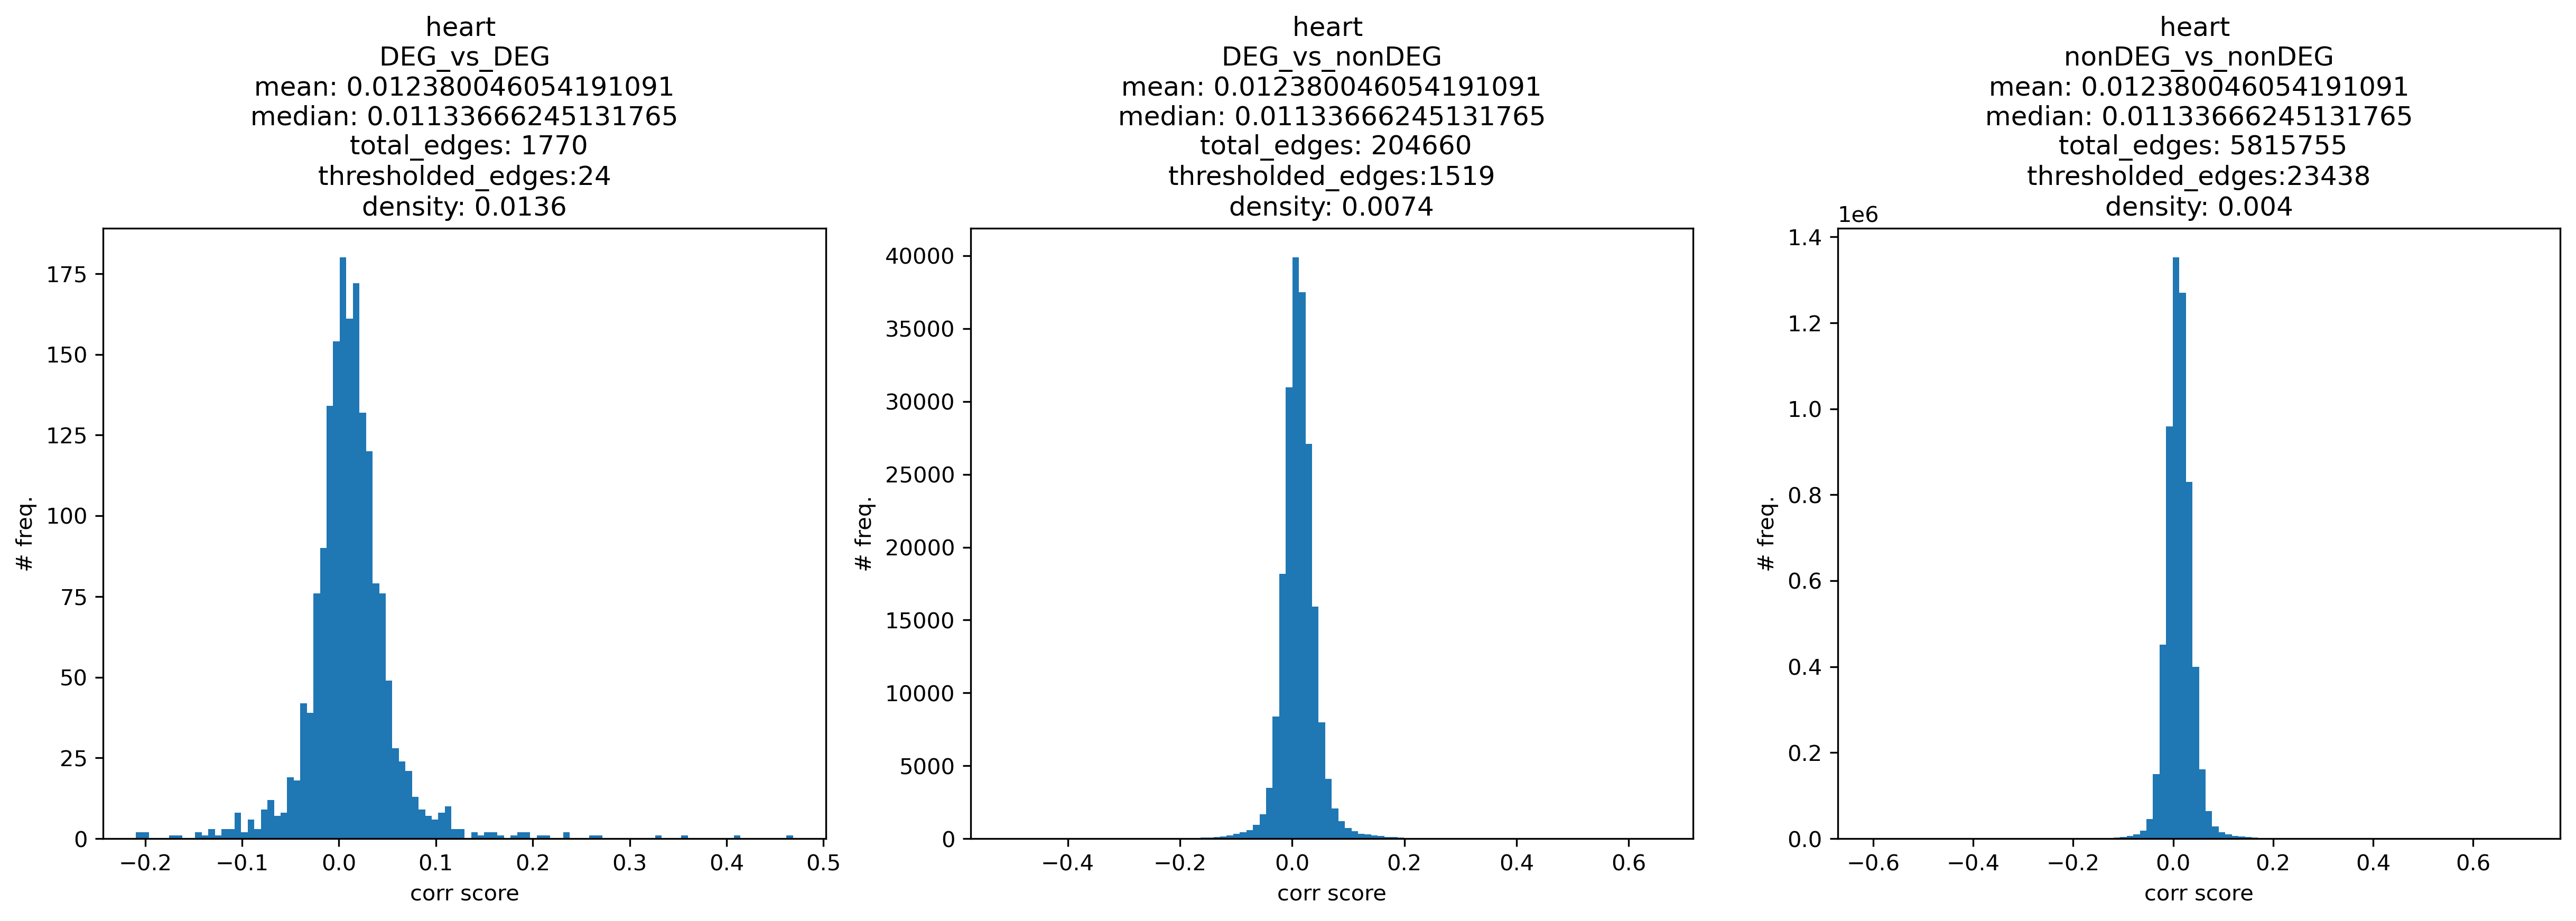

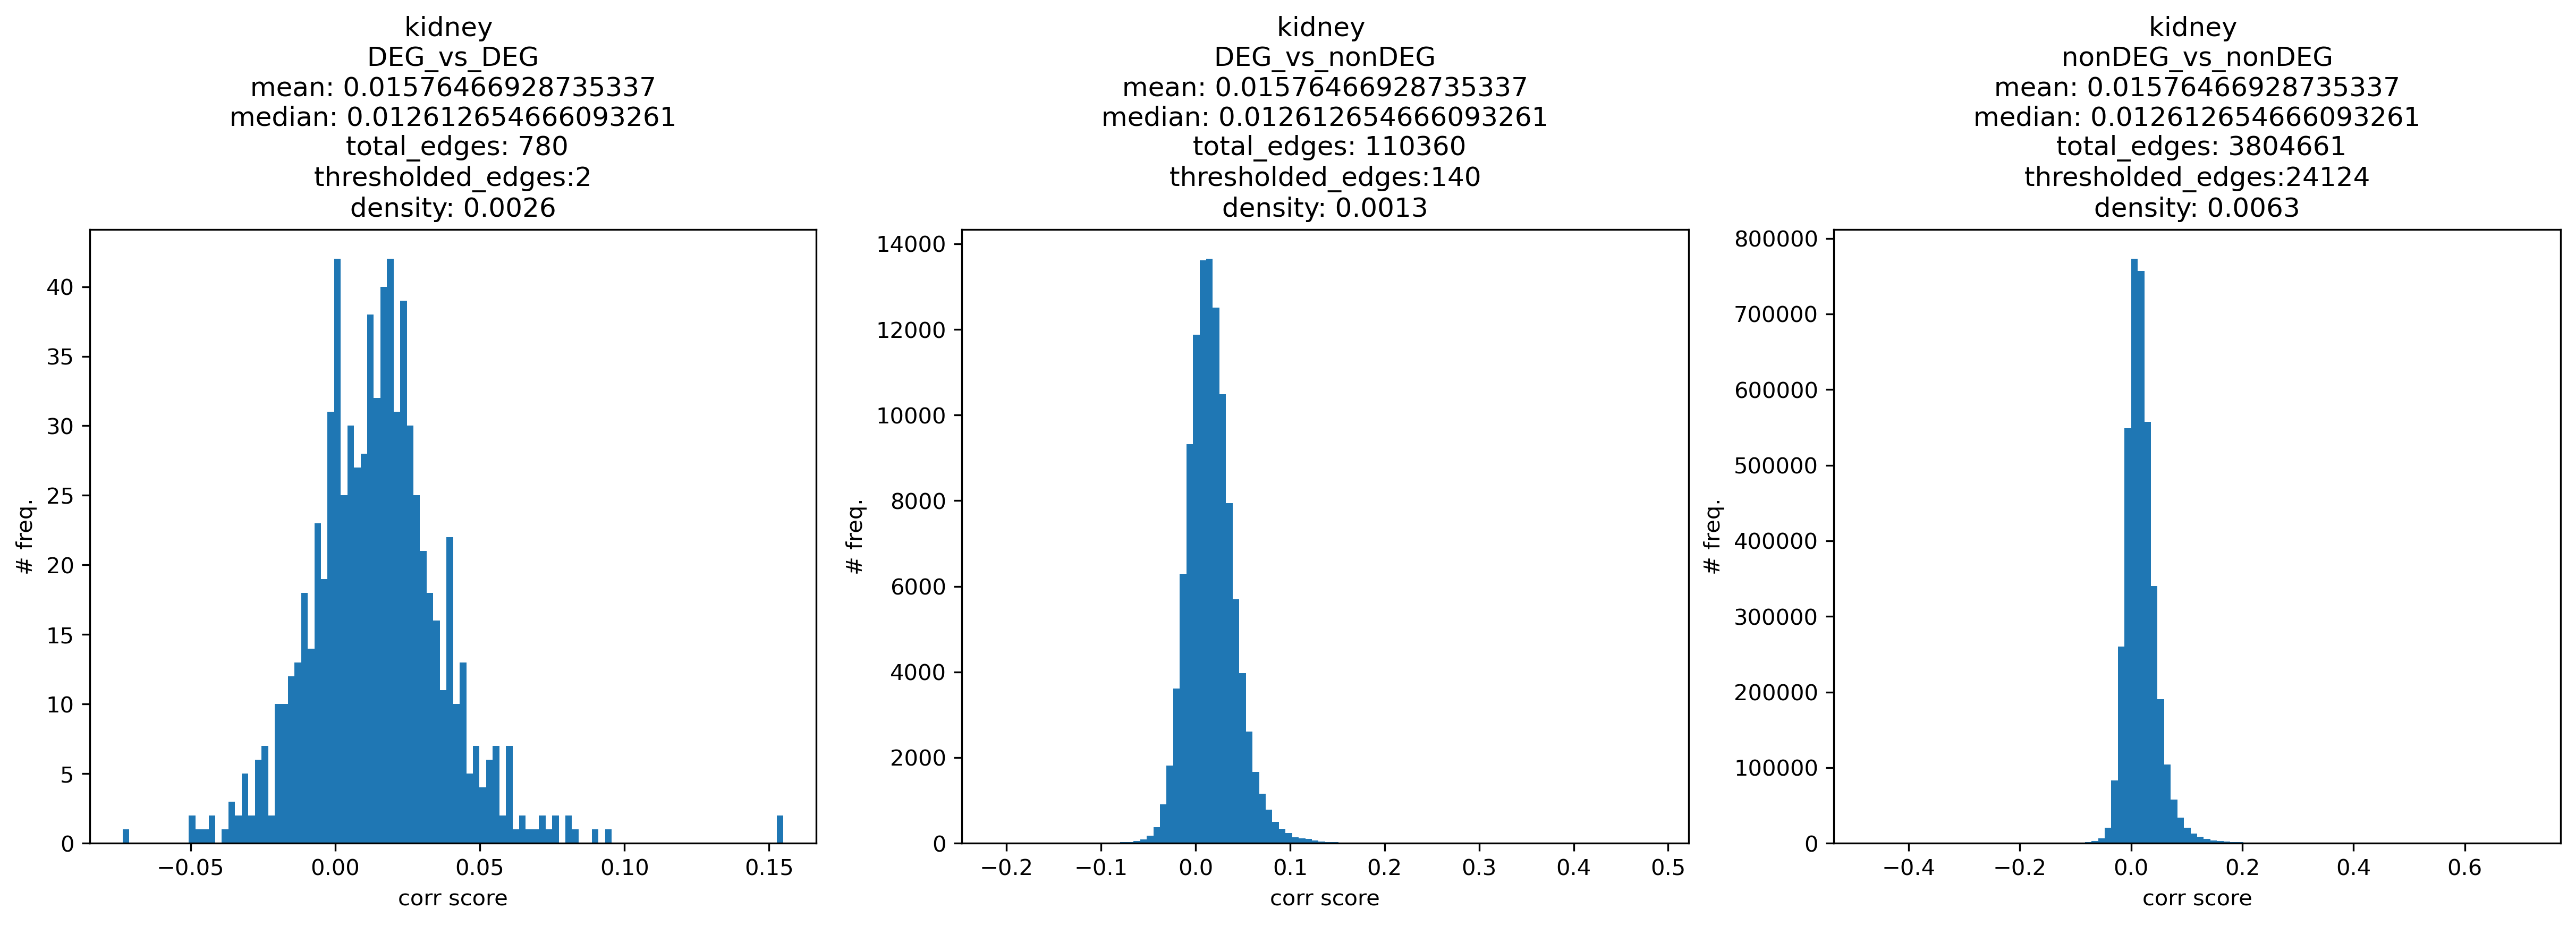

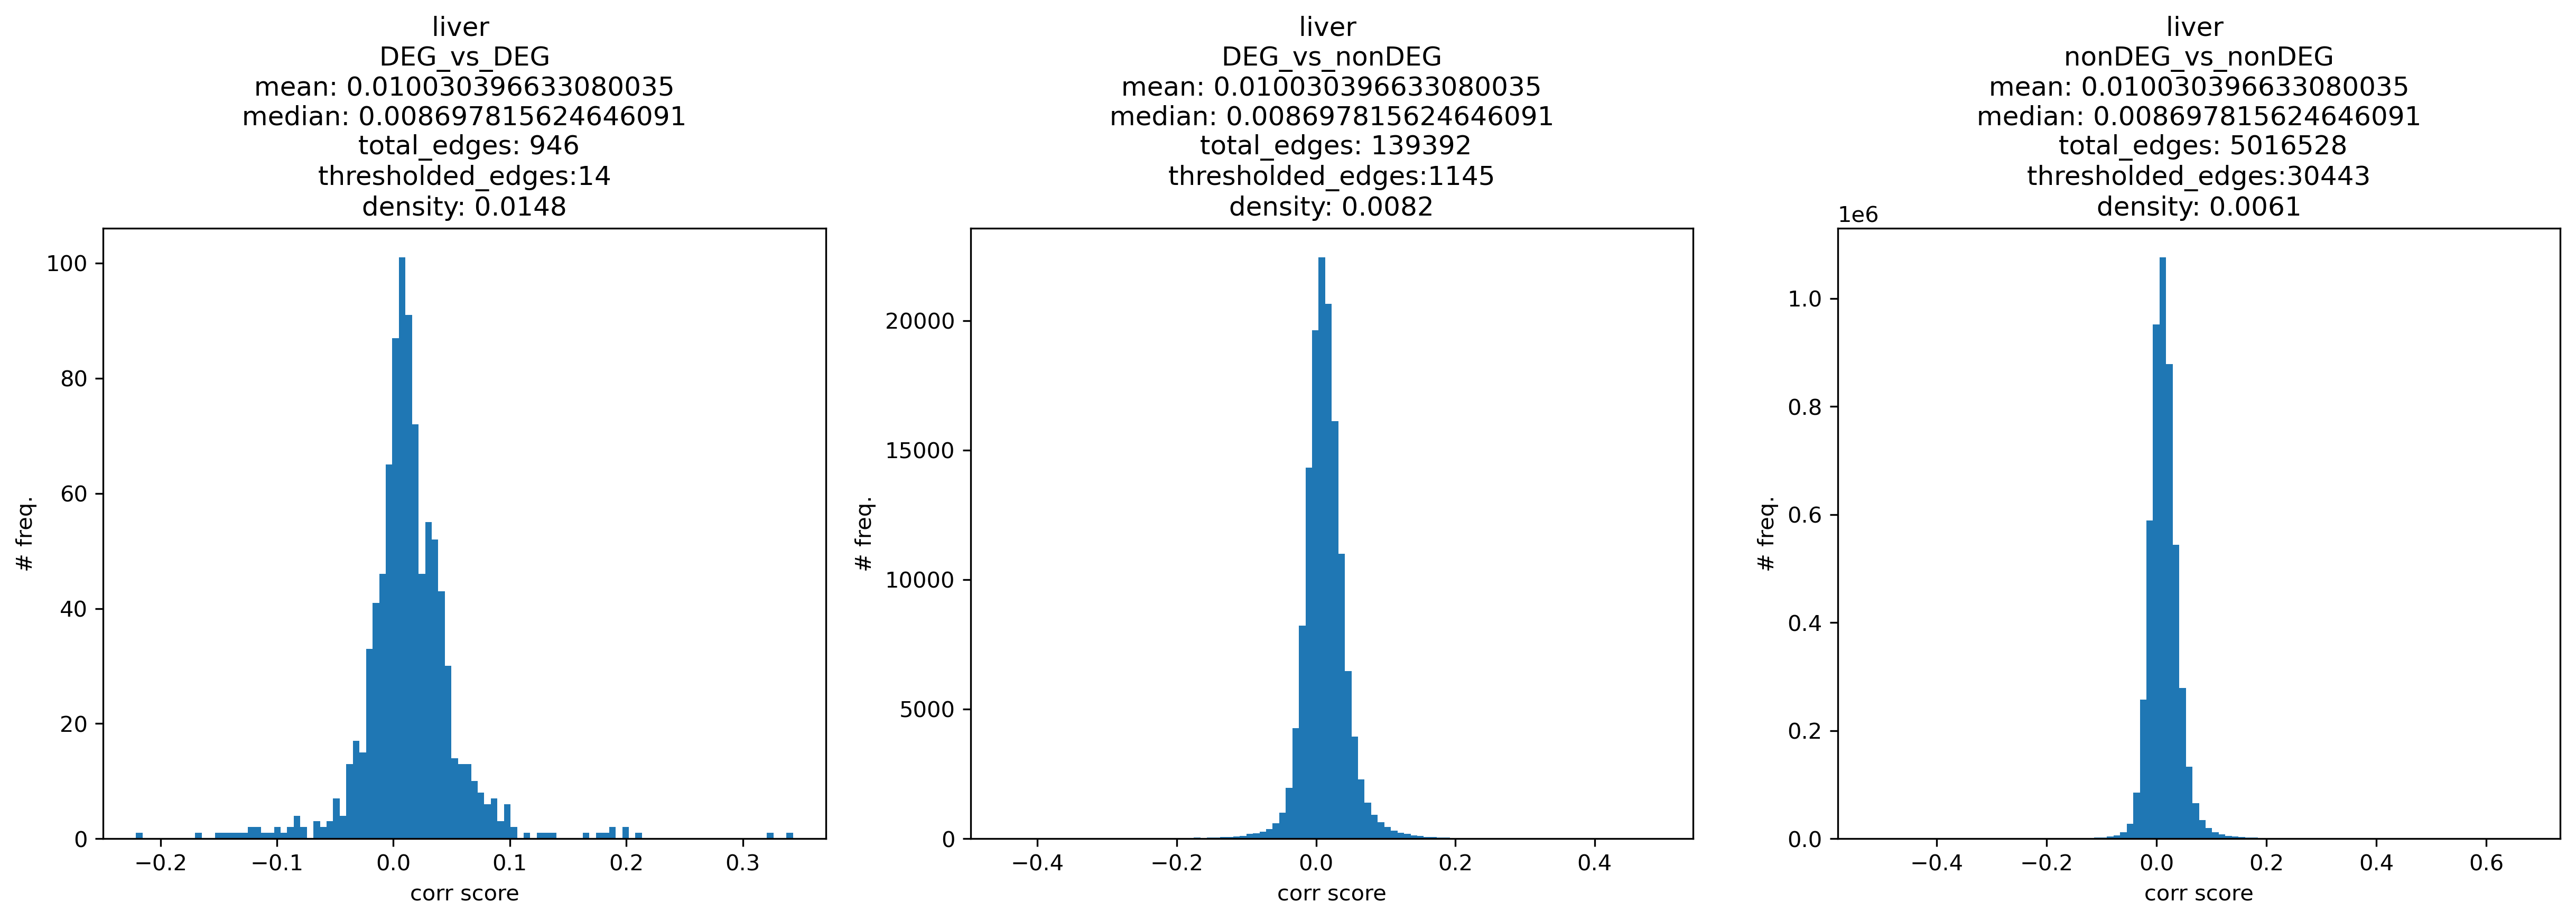

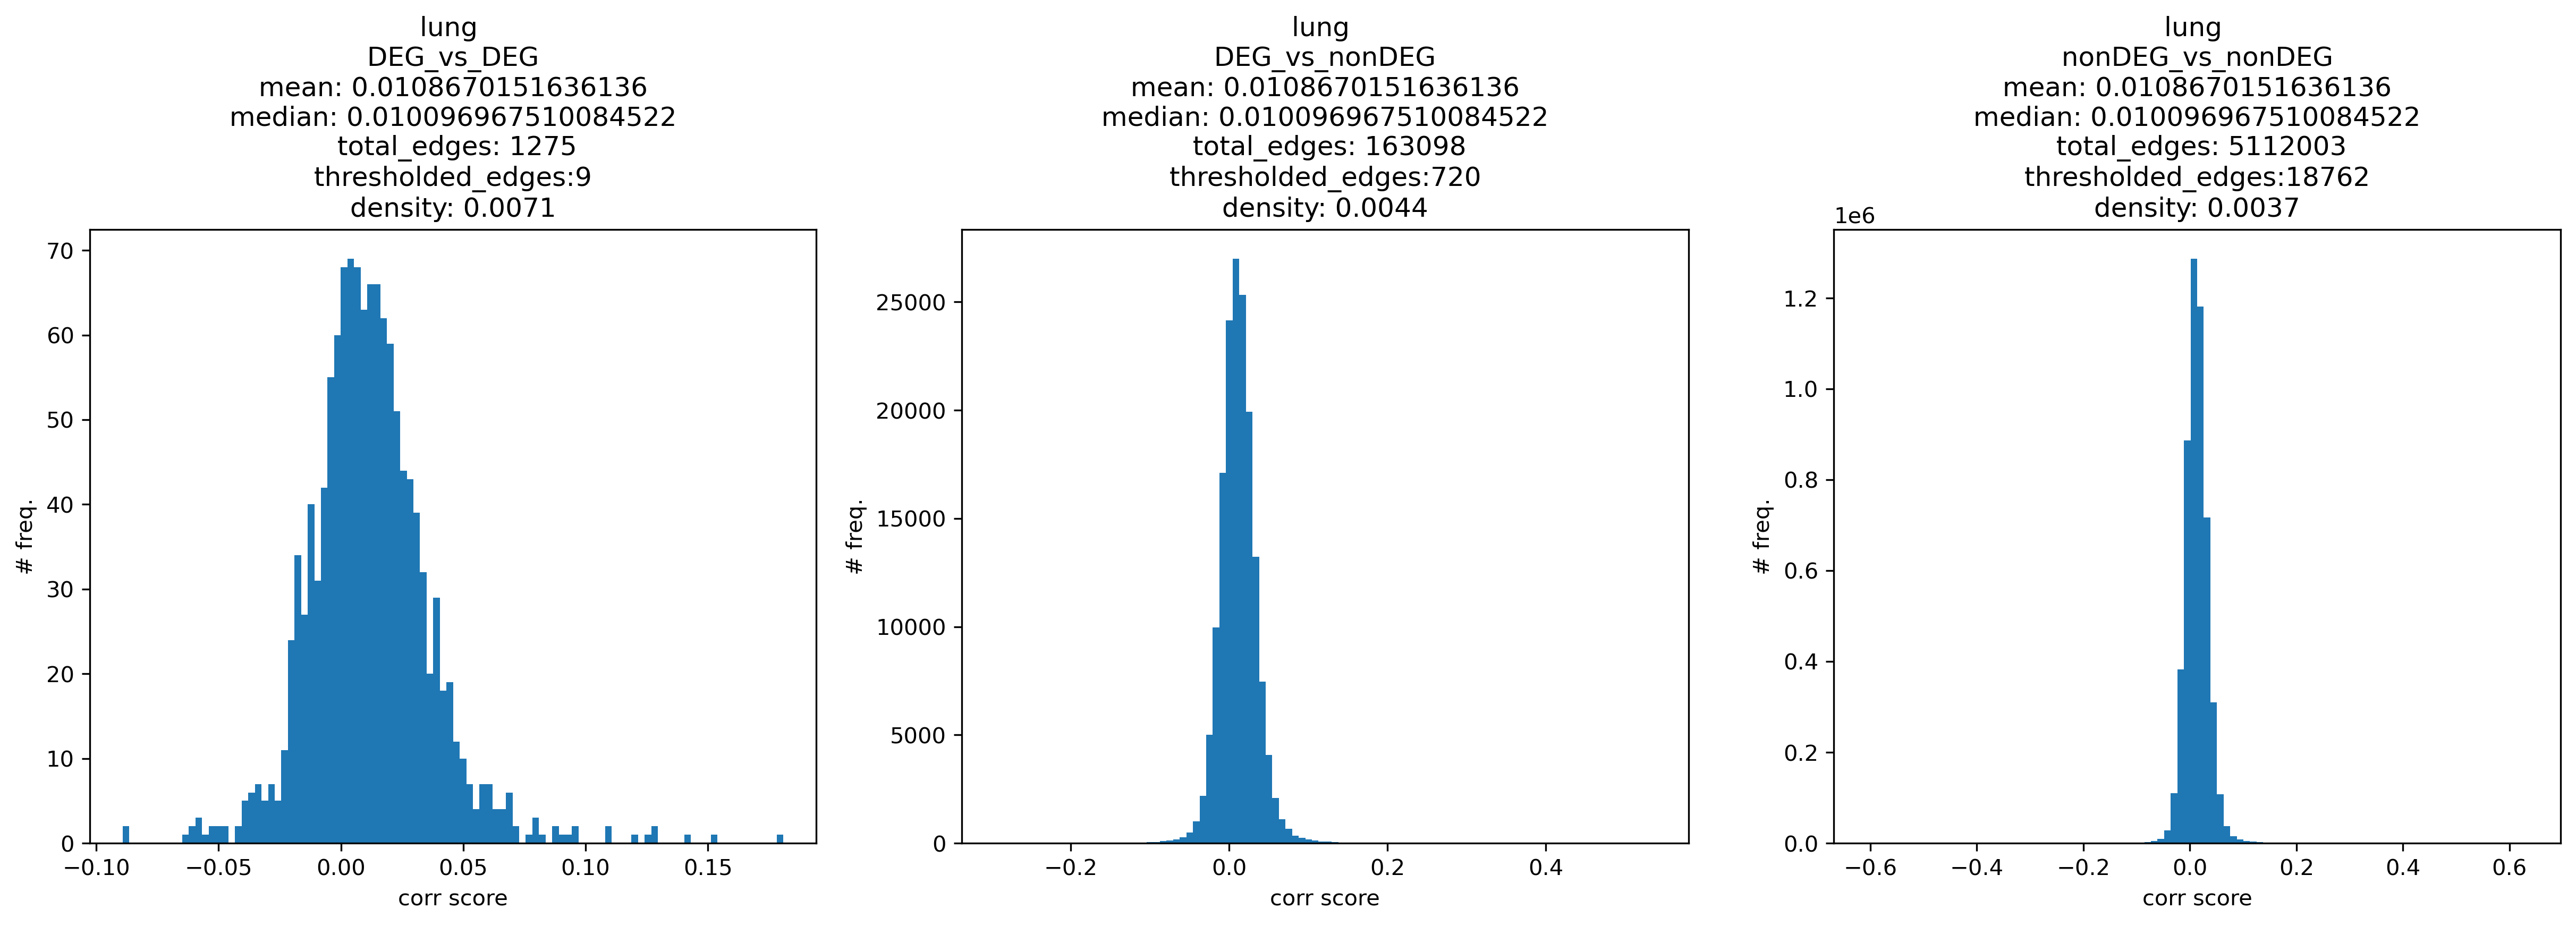

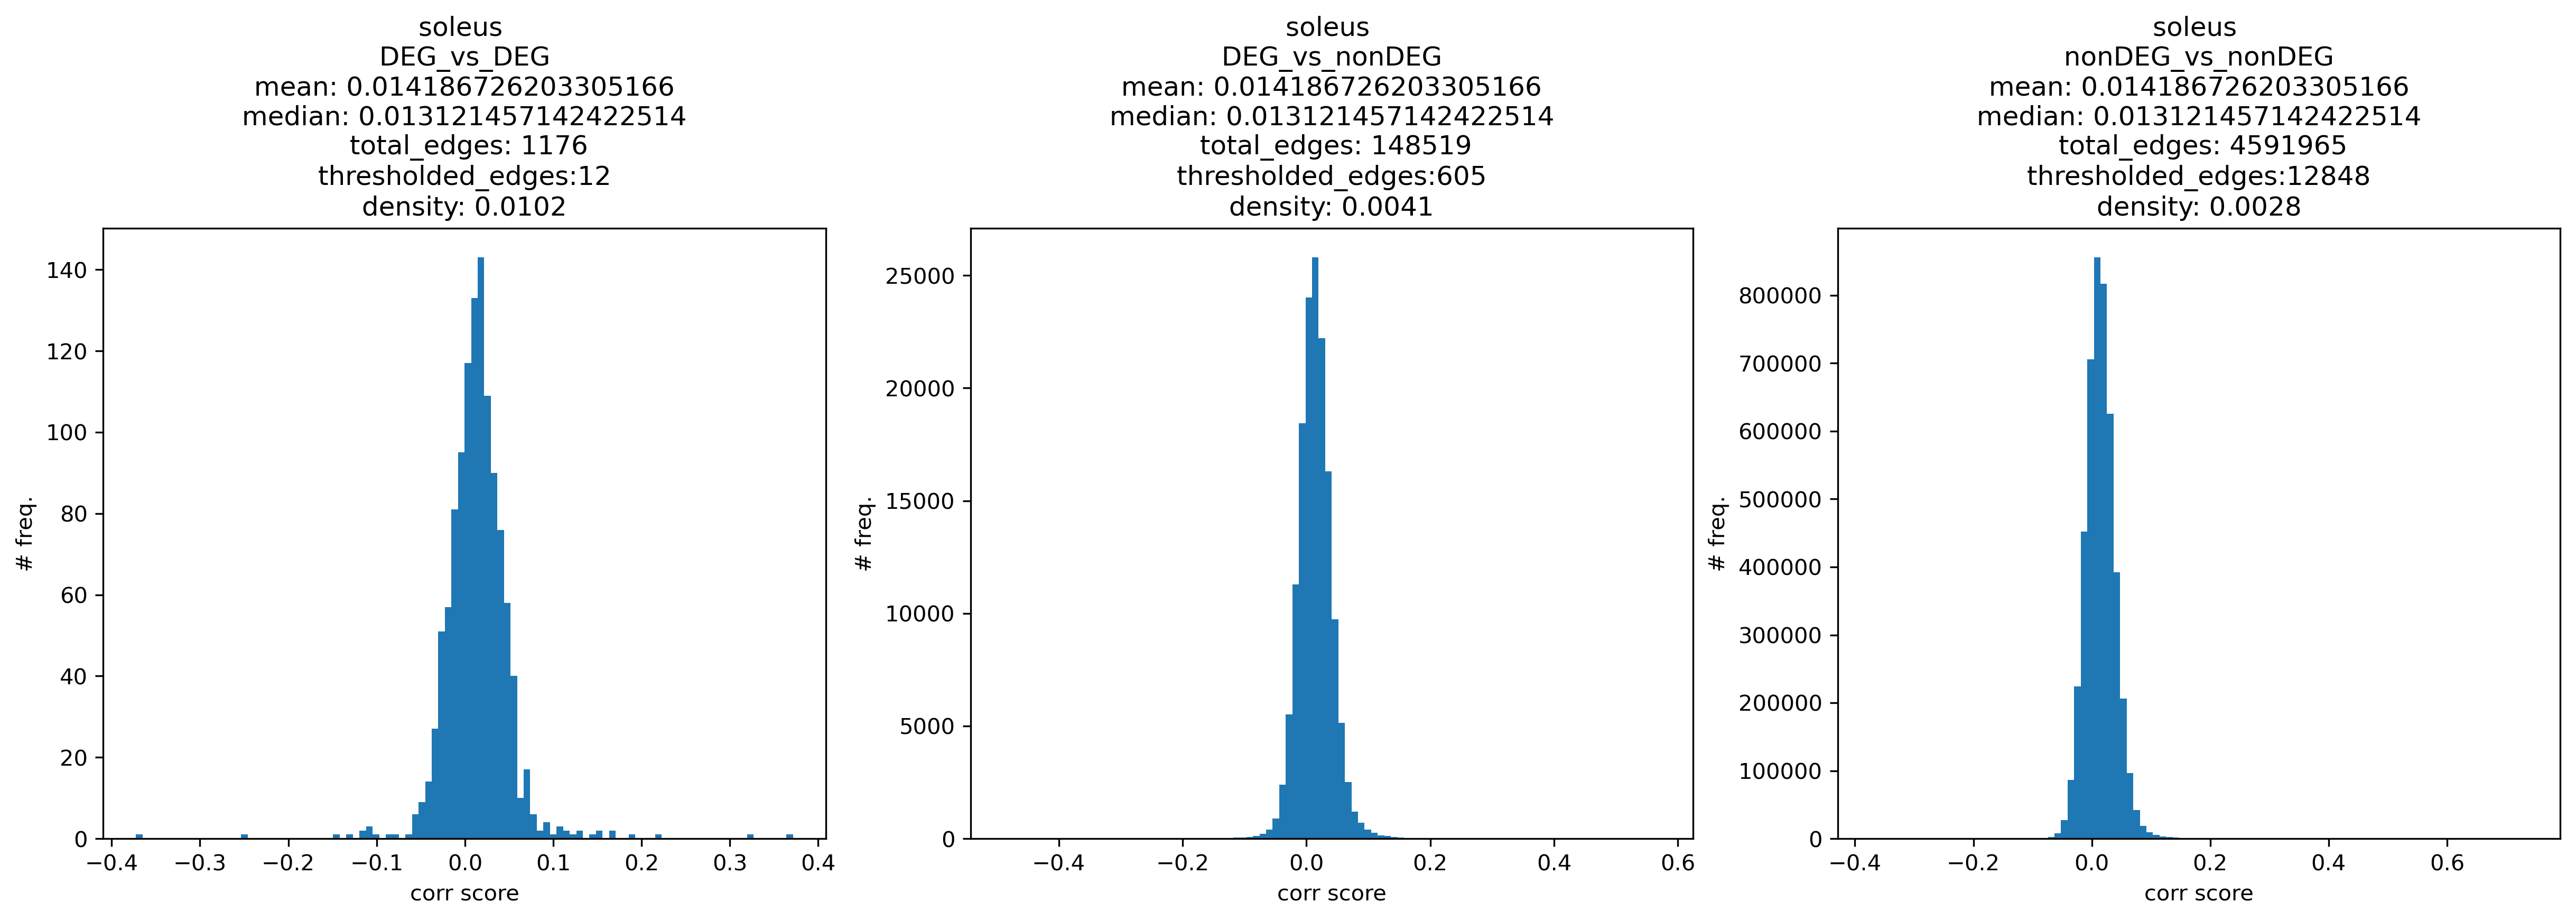

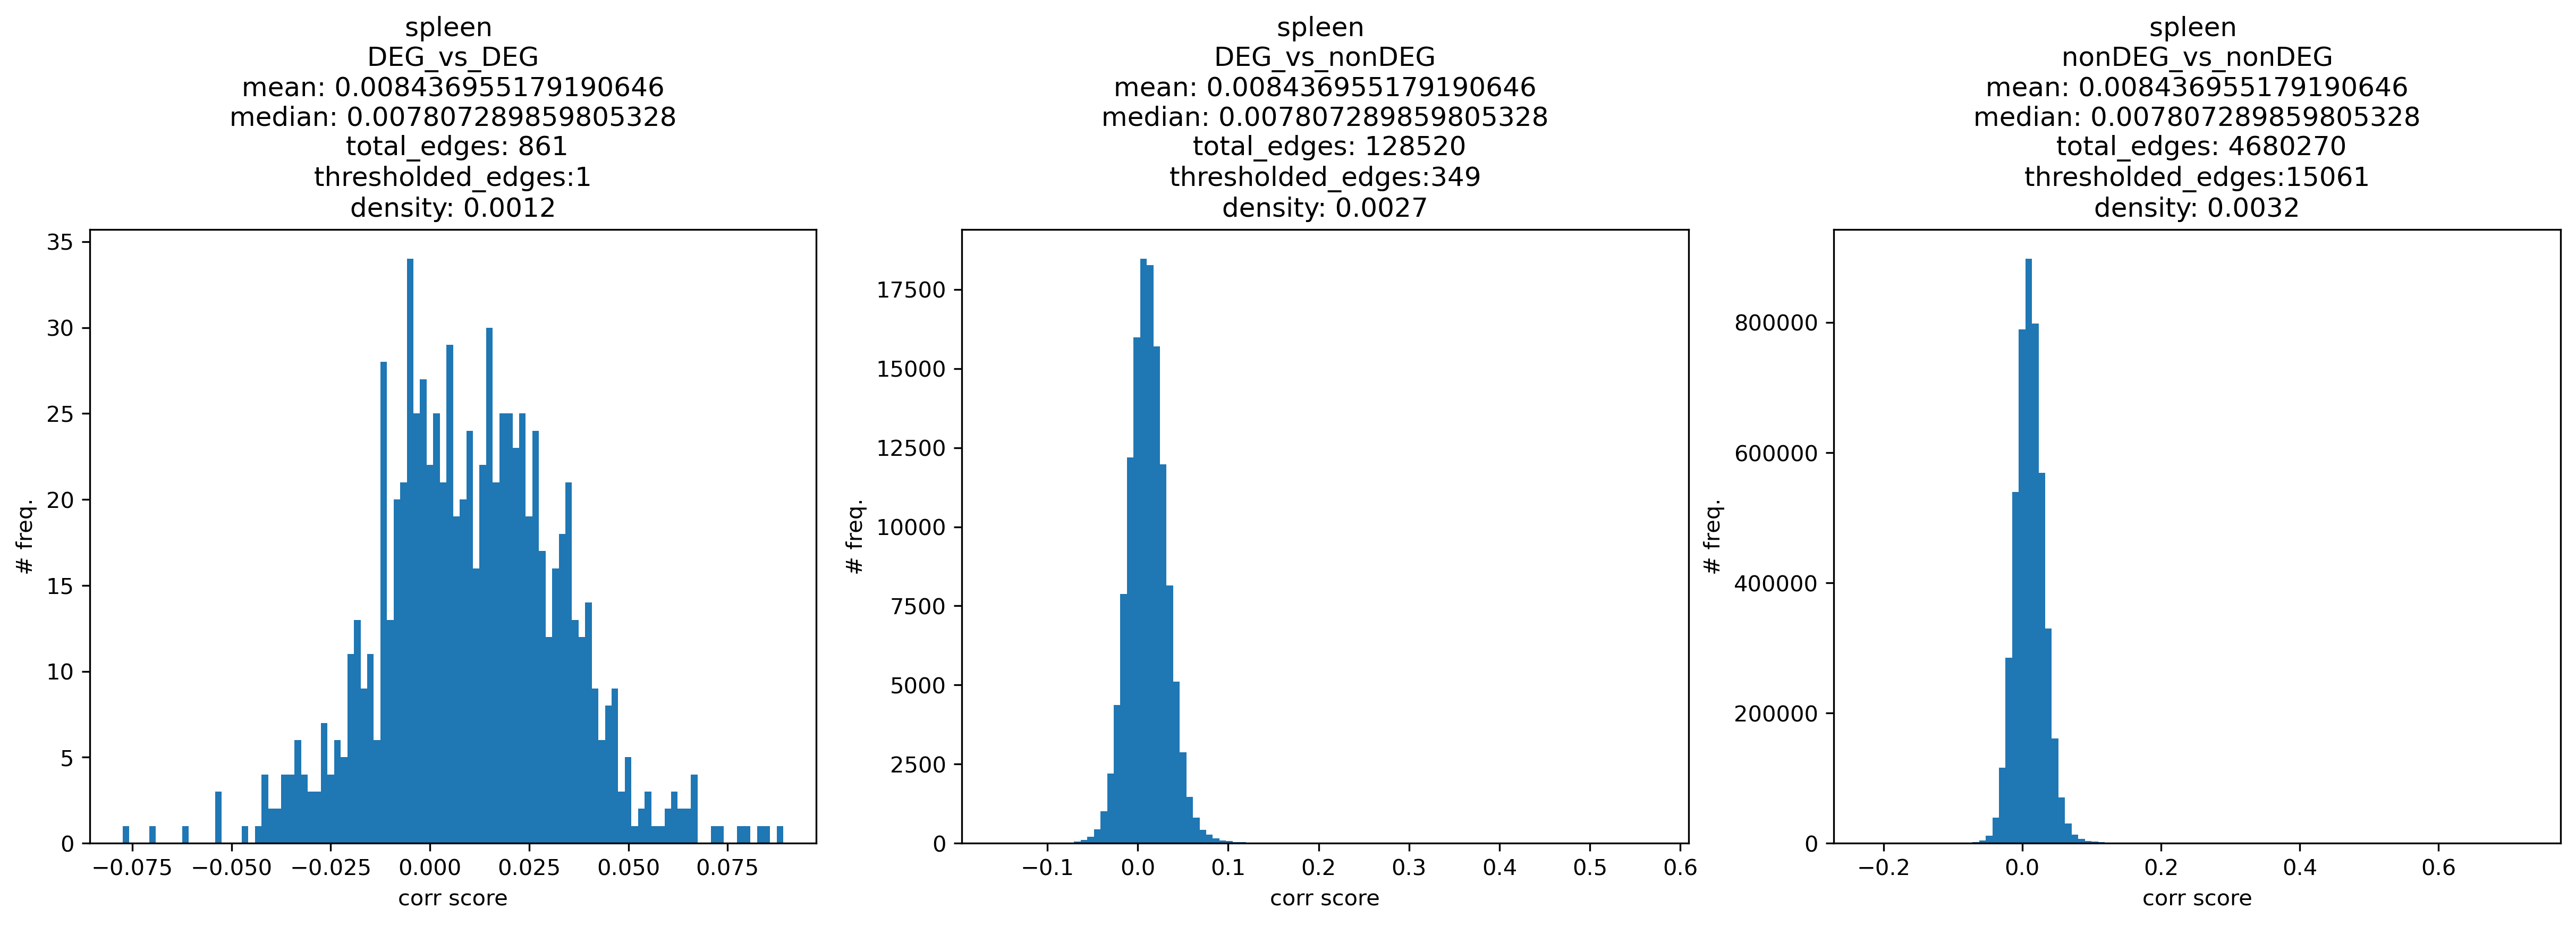

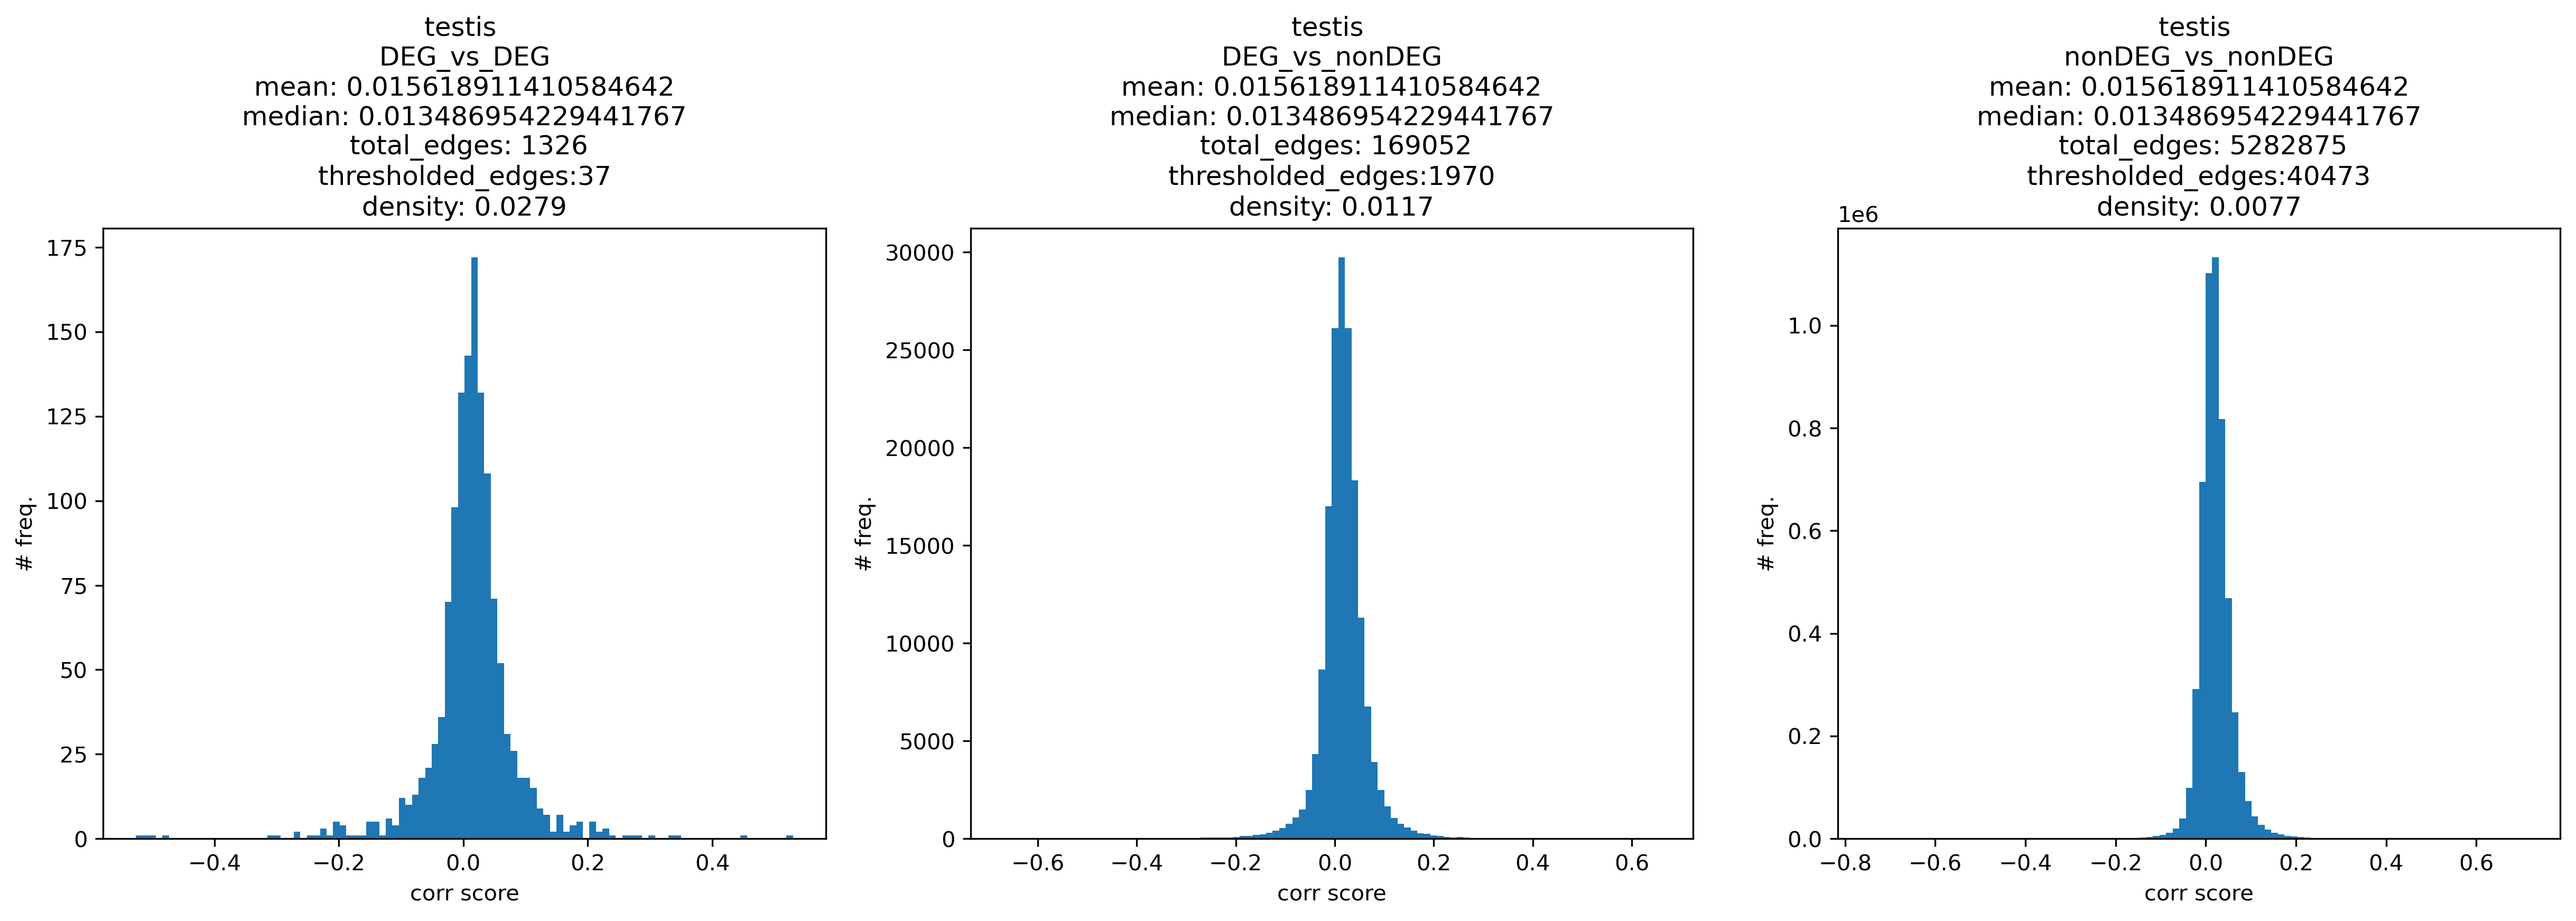

In [91]:
cases = {
    'DEG_vs_DEG': [ deg_filter[o], deg_filter[o] ],
    'DEG_vs_nonDEG': [deg_filter[o], list(set(universe_filter[o])-set(deg_filter[o])) ],
    'nonDEG_vs_nonDEG': [list(set(universe_filter[o])-set(deg_filter[o])), list(set(universe_filter[o])-set(deg_filter[o]))]
}

for o in organs:
    
    df = dfs[o].loc[ universe_filter[o] ].T
    stack, corr, threshold = do_corr(df)

    f, axes = plt.subplots(1,3, figsize=(20,5), dpi=300)
    i = 0
    for k,v in cases.items():
        matrix, t_matrix, density = filter_corr_matrix(stack, v[0], v[1], threshold)
        axes[i].hist(matrix['score'].values, bins=100)
        axes[i].set_xlabel('corr score')
        axes[i].set_ylabel('# freq.')
        axes[i].set_title(f'{o} \n {k} \n mean: {stack["score"].mean()} \n median: {stack["score"].median()} \n  total_edges: {matrix.index.size} \n thresholded_edges:{t_matrix.index.size} \n density: {round(density, 4)} ' )
        i += 1
    f.savefig(f'{o}.png', bbox_inches='tight')


compute mean for each organ with threshold and without

In [ ]:
means = {}
for organ in x.columns:

    deg_mean = dfs[organ].loc[common_genes_dict[organ]].stack().dropna().mean() 
    global_mean = dfs[organ].stack().dropna().mean()
    means[organ] = {'global': global_mean, 'deg_mean': deg_mean}
    
pd.DataFrame.from_dict(means,'index').T